# Make a DEM Cube

Get a DEM temperature distribution over the solar disk

In [1]:
import sys
import glob
import copy

import numpy as np
#import jax
#import jax.scipy
#import cupy
#import cupyx.scipy
from scipy.interpolate import interp1d
import astropy.units as u
import astropy.time
import astropy.wcs
import astropy.io.fits
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from sunpy.map import Map, make_fitswcs_header
from sunpy.net import Fido, attrs as a
from sunpy.net.attr import and_,or_
from sunpy.time import TimeRange
from sunpy.coordinates import Helioprojective
import sunpy.io
from ndcube import NDCube, NDCollection
from astropy.nddata import StdDevUncertainty
from astropy.visualization import (ImageNormalize, LogStretch, SqrtStretch, AsinhStretch,
                                   PowerStretch, quantity_support, AsymmetricPercentileInterval)
from aiapy.calibrate import register, estimate_error, correct_degradation
from sunkit_dem import Model
from sunkit_dem.models import HK12Model
import reproject

import distributed
from dask_gateway import Gateway, GatewayCluster

from overlappy.reproject import reproject_to_overlappogram
from overlappy.wcs import pcij_matrix, overlappogram_fits_wcs
from overlappy.util import color_lat_lon_axes, strided_array

sys.path.append('physics/dem')
from dem_models import (get_aia_temperature_response,
                        get_xrt_temperature_response,
                        PlowmanModel)
sys.path.append('physics/spectral')
from spectral_utils import read_spectral_table
sys.path.append('detector')
from response import SpectrogramChannel, Channel

#%load_ext snakeviz

In [2]:
# The following numbers are from Jake and Albert:
CDELT_SPACE = 5.66 * u.arcsec / u.pix
CDELT_WAVE = 55 * u.milliangstrom / u.pix
# This comes from the proposal:
DETECTOR_SHAPE_DISPERSED = (750, 2000)
DETECTOR_SHAPE_PINHOLE = (750, 475)

## Get Data

In [2]:
date = astropy.time.Time('2020-11-09 18:00:00') 
euv_wavelengths = or_(*[a.Wavelength(w) 
                        for w in [94,131,171,193,211,335]*u.angstrom])
q = Fido.search(a.Time(date, date+1*u.h, near=date),
                euv_wavelengths,
                a.Instrument.aia)

In [3]:
#files = Fido.fetch(q, path='../data/{instrument}')
files = sorted(glob.glob('data/AIA/*.fits'))

For now, I'm grabbing the Be-thin synoptic image from [here](http://solar.physics.montana.edu/HINODE/XRT/SCIA/synop_images/syncmp_FITS/2020/11/). Once the XRT data comes back online in the VSO, we'll just query it from there.

In [4]:
files += ['data/XRT/comp_XRT20201109_181902.6.fits']

## Build Data Cube

Reproject AIA and XRT images all into the same WCS and make estimates of the uncertainties.

In [5]:
cubes = []
ref_coordinate = SkyCoord(0,0,unit='arcsec', frame=Map(files[0]).coordinate_frame)
for f in files:
    m = Map(f)    
    # Construct new WCS to reproject to. This will resample and derotate each map to the same
    # frame
    new_header = make_fitswcs_header(
        (450,450),  # It doesn't really matter what this is as long as we include the full disk
        #(75, 75),
        ref_coordinate,
        scale=u.Quantity([5, 5], 'arcsec / pix'),
        #scale=u.Quantity([30,30], 'arcsec / pix'),
        rotation_angle=0*u.deg,
        instrument=m.instrument,
        observatory=m.observatory,
        wavelength=m.wavelength,
        exposure=m.exposure_time,
        projection_code='TAN',
    )
    new_header['BUNIT'] = str(m.unit / u.pix if m.unit is not None else u.ct / u.pix)
    if 'EC_FW1_' in m.meta:
        new_header['EC_FW1_'] = m.meta['EC_FW1_']
    if 'EC_FW2_' in m.meta:
        new_header['EC_FW2_'] = m.meta['EC_FW2_']
    with Helioprojective.assume_spherical_screen(m.observer_coordinate, only_off_disk=True):
        _m = m.reproject_to(astropy.wcs.WCS(new_header), algorithm='adaptive')  # switch to adaptive
    n_sample = int(np.round(m.dimensions.x / _m.dimensions.x))
    new_data = _m.data
    new_data[np.isnan(new_data)] = np.nanmin(new_data)
    m = Map(new_data, new_header)
    # REMOVE THIS BLOCK
    #blc = SkyCoord(Tx=-50*u.arcsec,Ty=-550*u.arcsec,frame=m.coordinate_frame)
    #m = m.submap(blc, width=200*u.arcsec, height=200*u.arcsec)
    # REMOVE THIS BLOCK
    # compute uncertainties
    if 'AIA' in m.instrument:
        m = correct_degradation(m)
        error = estimate_error(m.quantity, m.wavelength, n_sample=n_sample)
    else:
        # For XRT, just assume 20% uncertainty
        error = m.quantity*0.2
    error[np.isnan(error)] = 0.0 * error.unit
    ### WARNING: REMOVE THIS IF WE GO BACK TO PLOWMAN OR CHEUNG DEM METHODS ###
    ### AS THEY ASSUME UNITS OF DN, not DN s-1 ################################
    error /= m.exposure_time
    m /= m.exposure_time
    ###########################################################################
    error = StdDevUncertainty(error)
    # Build cube
    cube = NDCube(m.quantity, wcs=m.wcs, uncertainty=error, meta=m.meta, )
    cubes.append((str(m.measurement), cube))
map_collection = NDCollection(cubes, aligned_axes=(0,1))

/Users/willbarnes/anaconda/envs/moxsi-dev/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/willbarnes/anaconda/envs/moxsi-dev/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/willbarnes/anaconda/envs/moxsi-dev/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/willbarnes/anaconda/envs/moxsi-dev/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 10 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/willbarnes/anaconda/envs/moxsi-dev/lib/python3.9/site-pa

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


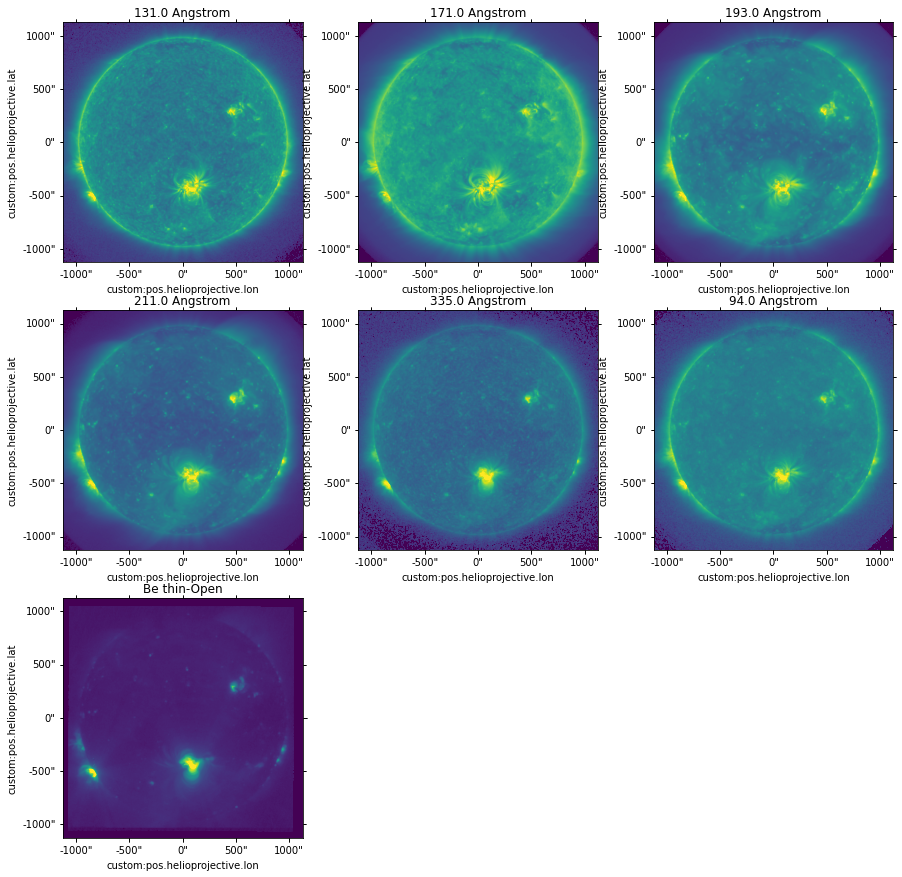

In [6]:
fig = plt.figure(figsize=(15,15))
for i,k in enumerate(map_collection):
    vmin,vmax = AsymmetricPercentileInterval(1,99.9).get_limits(map_collection[k].data)
    vmin = max(vmin,0)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=PowerStretch(0.3))
    ax = fig.add_subplot(3,3,i+1,projection=map_collection[k].wcs)
    map_collection[k].plot(axes=ax,norm=norm)
    ax.set_title(k)

## Response Functions

In [7]:
logt_bin_width = 0.1
logt = np.arange(5.7, 7.6, logt_bin_width)
temperature_bin_edges = 10**logt * u.K
temperature_bin_centers = 10**((logt[1:] + logt[:-1])/2) * u.K

In [8]:
aia_euv_channels = [94, 131, 171, 193, 211, 335] * u.angstrom
aia_responses = get_aia_temperature_response('data/aia_temperature_response.asdf', aia_euv_channels, temperature_bin_centers)
xrt_channels = ['Be_thin']
xrt_responses = get_xrt_temperature_response('data/xrt_temperature_response.asdf', xrt_channels, temperature_bin_centers,
                                             correction_factor=1)
all_responses = {**aia_responses, **xrt_responses}

(1e-28, 3e-24)

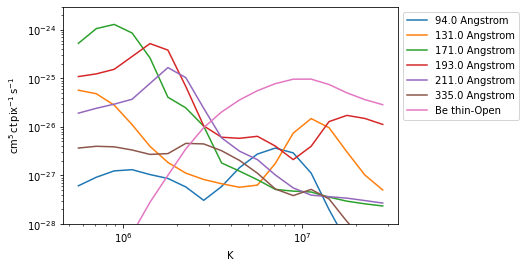

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
with quantity_support():
    for k in all_responses:
        ax.plot(temperature_bin_centers, all_responses[k], label=k)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylim(1e-28, 3e-24)

## Invert

In [109]:
simple_reg_model = Model(
    map_collection,
    {k: all_responses[k] for k in map_collection},
    temperature_bin_edges,
    model='plowman'
)

In [10]:
sparse_model = Model(
    map_collection,
    {k: all_responses[k] for k in map_collection},
    temperature_bin_edges,
    model='cheung'
)

In [10]:
reg_model = Model(
    map_collection,
    {k: all_responses[k] for k in map_collection},
    temperature_bin_edges,
    model='hk12'
)

In [24]:
client = distributed.Client()

In [25]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53940,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:53958,Total threads: 1
Dashboard: http://127.0.0.1:53960/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:53943,


In [11]:
#dem = reg_model.fit(method=None)
dem = reg_model.fit()

/Users/willbarnes/Documents/work/codes/sunkit-dem/sunkit_dem/models/hk12.py:411: RuntimeWarning: divide by zero encountered in true_divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/willbarnes/Documents/work/codes/sunkit-dem/sunkit_dem/models/hk12.py:412: RuntimeWarning: divide by zero encountered in true_divide
  dn=dnin/ednin
/Users/willbarnes/Documents/work/codes/sunkit-dem/sunkit_dem/models/hk12.py:413: RuntimeWarning: invalid value encountered in true_divide
  edn=ednin/ednin


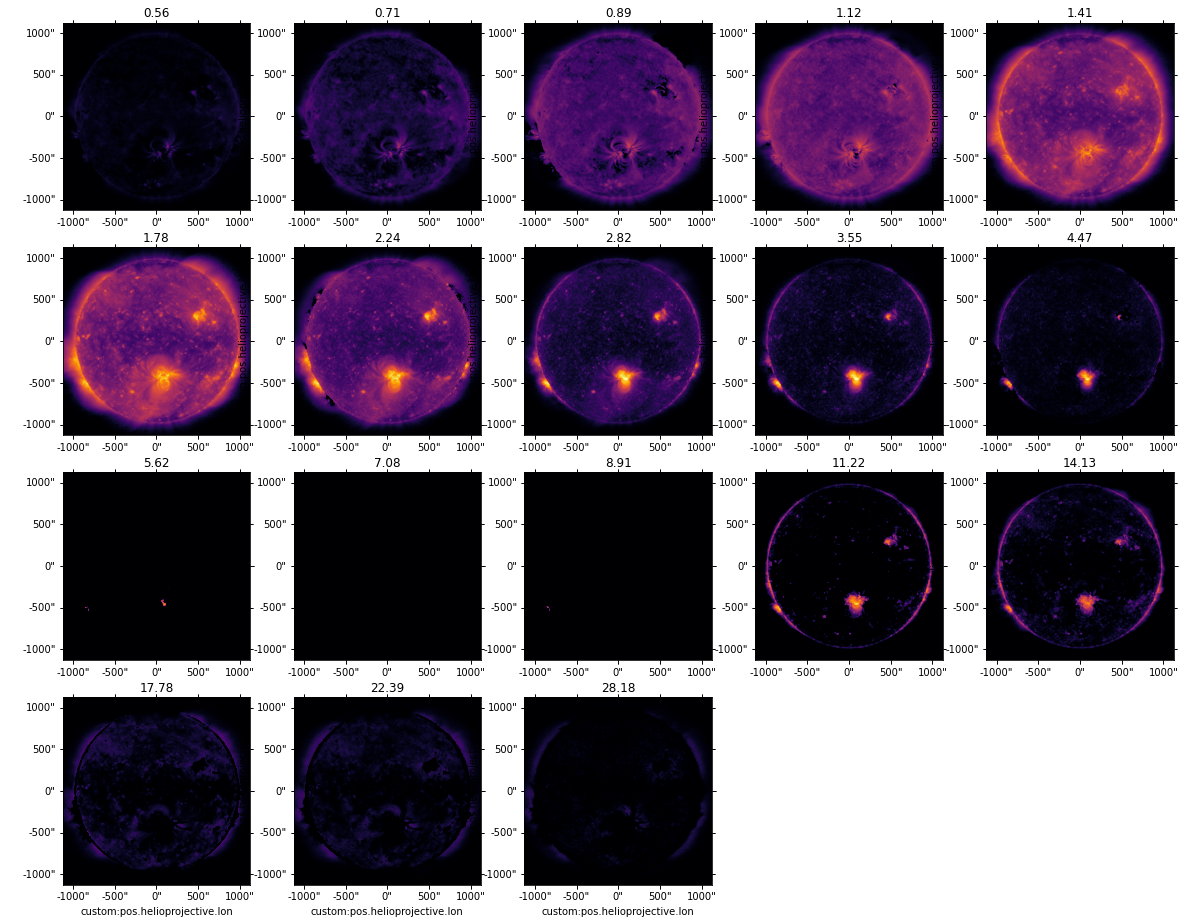

In [13]:
tbin_centers = dem['em'].axis_world_coords(0)[0]
norm = ImageNormalize(vmin=1e23,vmax=1e28,stretch=LogStretch())
fig = plt.figure(figsize=(20,20))
for i in range(int(dem['em'].dimensions[0].value)):
    ax = fig.add_subplot(5,5,i+1,projection=dem['dem'][i].wcs)
    dem['em'][i,...].plot(axes=ax, cmap='inferno', norm=norm)
    ax.set_title(f"{tbin_centers[i].to_value('MK'):0.2f}")
    if i%5 == 0:
        ax.coords[1].set_axislabel(' ')
    if i<15:
        ax.coords[0].set_axislabel(' ')

## Make Spectral Cube

In [14]:
spectral_tab = read_spectral_table('data/spectral-table.asdf')

/Users/willbarnes/anaconda/envs/moxsi-dev/lib/python3.9/site-packages/asdf/asdf.py:348: AsdfWarning: File 'file:///Users/willbarnes/Documents/work/projects/moxsi-tools/simulation_pipeline/data/spectral-table.asdf' was created with extension class 'asdf.extension.BuiltinExtension' (from package asdf==2.12.0), but older package (asdf==2.9.2) is installed.
  warnings.warn(msg, AsdfWarning)


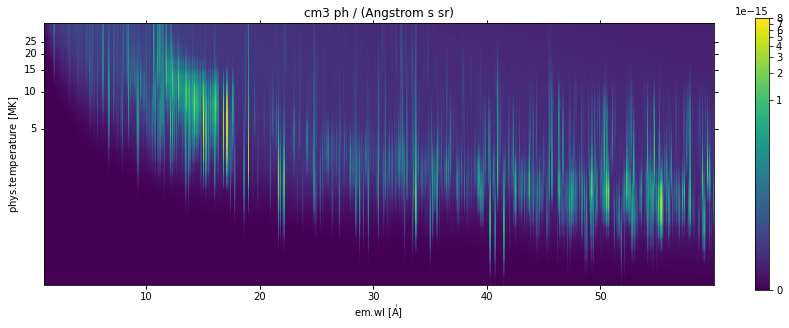

In [15]:
plt.figure(figsize=(15,5))
spectral_tab.plot(aspect=20, axes_units=('MK','Angstrom'), norm=ImageNormalize(stretch=LogStretch()))
plt.title(spectral_tab.unit)
plt.colorbar()

Now, compute the spectral cube from the DEM and spectral table.

First, interpolate the spectral table to the temperatures of the DEM

In [16]:
def calculate_spectral_cube(dem, spectra, celestial_wcs):
    """
    Convolve spectra with DEM to produce intensity cube
    
    Paramters
    ---------
    dem  : `~ndcube.NDCube`
        Array of DEM values, where the first dimension corresponds to the 
        temperature
    spectra : `~ndcube.NDCube`
        Array of spectra as a function of temperature and wavelength
    """
    temperature_bin_centers = dem.axis_world_coords(0)[0]
    wavelength_spectra = spectra.axis_world_coords(1)[0]
    temperature_spectra = spectra.axis_world_coords(0)[0].to(temperature_bin_centers.unit)
    # Interpolate spectral cube to detector wavelength and DEM temperatures
    spectra_interp = interp1d(temperature_spectra.value, spectra.data,
                              axis=0,)(temperature_bin_centers.value)
    # NOTE: Is this the right thing to do?
    spectra_interp[spectra_interp < 0] = 0.0
    # There may be NaNs from the inversion.
    # NOTE: in general, may be better to handle this before we get to this step
    dem_data = np.where(np.isnan(dem.data), 0.0, dem.data)
    # NOTE: Is this the right thing to do? Why are these negative?
    dem_data = np.where(dem_data < 0, 0.0, dem_data)
    # Convolve DEM and spectra
    _intensity = np.zeros((dem_data.shape[1]*dem_data.shape[2],)+wavelength_spectra.shape)
    for i in range(temperature_bin_centers.shape[0]):
        _intensity += np.outer(dem_data[i,:,:], spectra_interp[i,:],)
    # Reshape data array appropriately
    intensity_unit = dem.unit * spectra.unit
    intensity = _intensity.T.reshape(spectra_interp.shape[1:] + dem.data.shape[1:]) * intensity_unit
    # Create celestial WCS based on the FOV and observer position
    # The choice of the first channel is arbitrary, it does not affect the resulting WCS
    new_wcs = add_spectral_wcs(celestial_wcs, wavelength_spectra)
    # Add intensity axis
    return NDCube(intensity, wcs=new_wcs, meta=spectra.meta)


def add_spectral_wcs(celestial_wcs, wavelength):
    wcs_header = celestial_wcs.to_header()
    # NOTE: this assumes that the wavelength dimension is linear
    wcs_header['CDELT3'] = np.diff(wavelength)[0].value
    wcs_header['CUNIT3'] = wavelength.unit.to_string()
    wcs_header['CRPIX3'] = 0
    wcs_header['CRVAL3'] = wavelength[0].value
    wcs_header['CTYPE3'] = 'WAVE'
    return astropy.wcs.WCS(header=wcs_header)

In [17]:
spectral_cube = calculate_spectral_cube(dem['em'], spectral_tab, map_collection['171.0 Angstrom'].wcs)

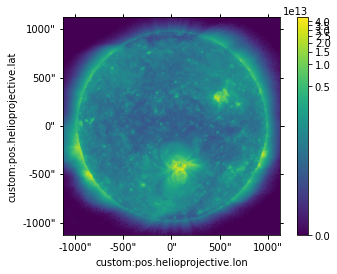

In [20]:
spectral_cube[900,...].plot(norm=ImageNormalize(stretch=LogStretch()))
plt.colorbar()

Save this result out here!!

In [3]:
header = spectral_cube.wcs.to_header()
header['BUNIT'] = spectral_cube.unit.to_string()
sunpy.io._fits.write('spectral-cube-example.fits',
                     spectral_cube.data,
                     header,
                     hdu_type=CompImageHDU)

NameError: name 'spectral_cube' is not defined

And read it back in

In [3]:
def read_cube(filename, hdu=0):
    with astropy.io.fits.open(filename) as hdul:
        data = hdul[hdu].data
        header = hdul[hdu].header
        header.pop('KEYCOMMENTS', None)
        wcs = astropy.wcs.WCS(header=header)
        spec_cube = NDCube(data, wcs=wcs, meta=header, unit=header.get('BUNIT', None))
    return spec_cube

In [4]:
spectral_cube = read_cube('spectral-cube-example.fits', hdu=1)

## Convert to Instrument Units

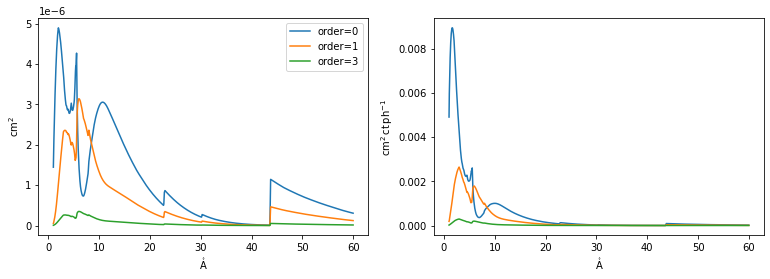

In [8]:
plt.figure(figsize=(13,4))
with quantity_support():
    plt.subplot(121)
    for order in [0,1,3]:
        chan = SpectrogramChannel(order, 'data/MOXSI_effarea.genx')
        plt.plot(chan.wavelength, chan.effective_area, label=f'order={order}')
    #plt.yscale('log')
    plt.legend()
    plt.subplot(122)
    for order in [0,1,3]:
        chan = SpectrogramChannel(order, 'data/MOXSI_effarea.genx')
        plt.plot(chan.wavelength, chan.wavelength_response)
    #plt.yscale('log')

In [5]:
def convolve_with_response(cube, channel):
    """
    Convolve spectral cube with wavelength response to convert spectra to instrument units.
    
    Parameters
    ----------
    cube : `ndcube.NDCube`
    channel : `Channel`
    
    Return
    ------
    : `ndcube.NDCube`
        Spectral cube in detector units convolved with instrument response
    """
    # FIXME: this should go in the Channel object
    plate_scale = CDELT_SPACE * CDELT_SPACE * u.pix
    # Interpolate wavelength response to wavelength array of spectral cube
    wavelength = cube.axis_world_coords(0)[0].to_value('Angstrom')
    f_response = interp1d(channel.wavelength.to_value('Angstrom'),
                          channel.wavelength_response.to_value(),
                          bounds_error=False,
                          fill_value=0.0,)  # Response is 0 outside of the response range
    response = u.Quantity(f_response(wavelength), channel.wavelength_response.unit)
    response *= plate_scale
    response *= CDELT_WAVE * u.pix
    
    # Multiply by spectral cube
    data = (cube.data.T * cube.unit * response).T 
    
    meta = copy.deepcopy(cube.meta)
    meta['channel_name'] = channel.name
    
    return NDCube(data.to('ct pix-1 s-1'), wcs=cube.wcs, meta=meta)

In [6]:
spectra_inst = convolve_with_response(spectral_cube, SpectrogramChannel(1, 'data/MOXSI_effarea.genx'))

## Reproject

Reproject the spectral cube to the dispersed image on the detector

In [7]:
def reproject_to_overlappogram_parallelized(cube,
                                            detector_shape,
                                            reference_pixel=None,
                                            reference_coord=None,
                                            scale=None,
                                            roll_angle=0*u.deg,
                                            dispersion_angle=0*u.deg,
                                            dispersion_axis=0,
                                            order=1,
                                            observer=None,
                                            sum_over_lambda=True,
                                            reproject_kwargs=None,
                                            meta_keys=None):
    
    wavelength = cube.axis_world_coords(0)[0].to('angstrom')
    pc_matrix = pcij_matrix(roll_angle, dispersion_angle,
                            order=order, dispersion_axis=dispersion_axis)
    if scale is None:
        scale = [u.Quantity(cd, f'{cu} / pix') for cd, cu in
                 zip(cube.wcs.wcs.cdelt, cube.wcs.wcs.cunit)]

    reproject_kwargs = {} if reproject_kwargs is None else reproject_kwargs
    
    
    # Iterate over each slice, adjusting the reference pixel at each iteration
    # Making this a function to enable parallelism
    # If using dask, probably want to scatter the data cube first
    def _reproject_slice(index, data_cube=None):
        slice_reference_pixel = copy.deepcopy(reference_pixel)
        # note: this still assumes that the reference wavelength maps to 0
        slice_reference_pixel[2] = (-index + 1) * u.pix
        slice_wcs = overlappogram_fits_wcs(
            detector_shape,
            wavelength[index:index+1],
            scale,
            reference_pixel=slice_reference_pixel,
            reference_coord=reference_coord,
            pc_matrix=pc_matrix,
            observer=observer,
        )
        out_array = reproject.reproject_interp(
            data_cube[index:index+1],
            slice_wcs,
            shape_out=(1,) + detector_shape,
            return_footprint=False,
            **reproject_kwargs,
        )
        return out_array.squeeze()
    
    
    client = distributed.get_client()
    cube_scattered = client.scatter(cube)
    slice_futures = client.map(_reproject_slice, range(cube.data.shape[0]), data_cube=cube_scattered)
    overlap_slices = client.gather(slice_futures)

    # Stack all arrays
    overlap_data = np.array(overlap_slices)
    
    if sum_over_lambda:
        isnan = np.where(np.isnan(overlap_data))
        overlap_data[isnan] = 0.0
        overlap_data = overlap_data.sum(axis=0)
        overlap_data = strided_array(overlap_data, wavelength.shape[0])

    meta = {}
    if meta_keys is not None:
        for k in meta_keys:
            meta[k] = cube.meta.get(k)
    
    # rebuild full wcs
    overlap_wcs = overlappogram_fits_wcs(
        detector_shape,
        wavelength,
        scale,
        reference_pixel=reference_pixel,
        reference_coord=reference_coord,
        pc_matrix=pc_matrix,
        observer=observer,
    )

    return NDCube(overlap_data, wcs=overlap_wcs, unit=cube.unit, meta=meta)

In [8]:
observer = astropy.wcs.utils.wcs_to_celestial_frame(spectral_cube.wcs).observer

In [9]:
order = 1
spectral_cube_instr = convolve_with_response(spectral_cube, SpectrogramChannel(order, 'data/MOXSI_effarea.genx'))

Let's build a function that does the reprojection for each slice individually

First, setup dask client

In [22]:
gateway = Gateway(address='https://daskhub.helio.mysmce.com')
#options = gateway.cluster_options()
#options.worker_cores=2
#options.worker_memory='4GB'
cluster = gateway.new_cluster()

ClientResponseError: 405, message='Method Not Allowed', url=URL('https://daskhub.helio.mysmce.com/api/v1/clusters/')

In [ ]:
cluster

In [ ]:
# create client, show url we can go to to monitor progress
client = Client(cluster)
client

In [14]:
overlap_test = reproject_to_overlappogram_parallelized(
    spectral_cube_instr[:15],
    DETECTOR_SHAPE_DISPERSED,
    scale=(CDELT_SPACE, CDELT_SPACE, CDELT_WAVE),
    reference_pixel=(
      (DETECTOR_SHAPE_DISPERSED[1] + 1)/2,
      (DETECTOR_SHAPE_DISPERSED[0] + 1)/2,
      1,
    ) * u.pix,
    roll_angle=-90*u.deg,  # orient such that solar-N points along the +1 dispersed direction
    dispersion_angle=0*u.deg,
    order=order,
    observer=observer,
    sum_over_lambda=True,
)

Text(0.5, 1.0, '1.05 Angstrom')

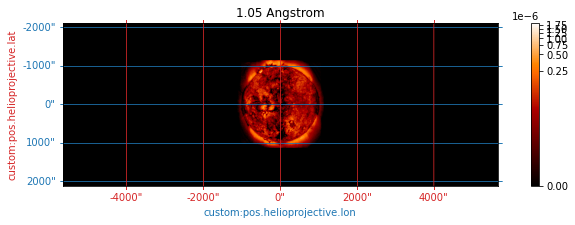

In [16]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111, projection=overlap_test[0].wcs)
overlap_test[0].plot(axes=ax, cmap='hinodexrt', norm=ImageNormalize(stretch=LogStretch()))
plt.colorbar()
color_lat_lon_axes(ax)
ax.set_title(f"{overlap_test.axis_world_coords(0)[1][0].to('Angstrom'):.02f}")

And now finally apply this for all five orders

In [ ]:
overlappograms = []
orders = [-3, -1, 0, 1, 3]
for order in orders:
    chan = SpectrogramChannel(order, 'data/MOXSI_effarea.genx')
    _spec_cube = convolve_with_response(spectral_cube, chan)
    _overlap = project_to_detector(_spec_cube, order)
    overlappograms.append(_overlap)

## Sandbox

In [12]:
def project_to_detector(cube, order, observer=None, ref_wave=None, ref_wave_pix=1, reproject_kwargs=None):
    if observer is None:
        # This does not always work in cases where the WCS is not a FITS WCS
        observer = astropy.wcs.utils.wcs_to_celestial_frame(cube.wcs).observer
    if ref_wave is None:
        ref_wave = cube.axis_world_coords(0)[0][0]
    # FIXME: need to pass dispersion_axis argument through to this function; the default is fine here
    return reproject_to_overlappogram(cube,
                                      DETECTOR_SHAPE_DISPERSED,
                                      scale=(CDELT_SPACE, CDELT_SPACE, CDELT_WAVE),
                                      reference_coord=(0*u.arcsec, 0*u.arcsec, ref_wave),
                                      reference_pixel=(
                                          (DETECTOR_SHAPE_DISPERSED[1] + 1)/2,
                                          (DETECTOR_SHAPE_DISPERSED[0] + 1)/2,
                                          ref_wave_pix,
                                      ) * u.pix,
                                      roll_angle=-90*u.deg,  # orient such that solar-N points along the +1 dispersed direction
                                      dispersion_angle=0*u.deg,
                                      order=order,
                                      observer=observer,
                                      sum_over_lambda=True,
                                      reproject_kwargs=reproject_kwargs)

In [13]:
wave = spectral_cube.axis_world_coords(0)[0]

In [10]:
def jax_map_coordinates_wrapper(*args, **kwargs):
    output = jax.scipy.ndimage.map_coordinates(*args, **kwargs)
    output = np.array(jax.device_get(output))
    return output

In [21]:
%%snakeviz
i_select = 300
overlap_p1 = project_to_detector(
    #convolve_with_response(spectral_cube, SpectrogramChannel(order, 'data/MOXSI_effarea.genx'))[i_select:i_select+1,:,:],
    #spectral_cube_instr_jax[:5,:,:],
    spectral_cube_instr[:10,:,:],
    order,
    observer=observer,
    #ref_wave=wave[0],
    #ref_wave_pix=-i_select+1,
    reproject_kwargs={
    #    'map_coords_func': jax_map_coordinates_wrapper,
        'roundtrip_coords': False,
    },
)

 
*** Profile stats marshalled to file '/var/folders/wz/hhl6rk5s76bfmczhttkt8vbr0000gn/T/tmp515htrsh'.
Embedding SnakeViz in this document...
